In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from math import sqrt

In [2]:
def get_dataset(csv_path, sheet_name):
  df = pd.read_excel(csv_path, sheet_name=sheet_name)
  return df
def get_input_df(df_se, df_s, df_ne, df_n, input_name):
  input_df = pd.concat([df_se['ini_date'],df_se[f'{input_name}'],df_s[f'{input_name}'],df_ne[f'{input_name}'],df_n[f'{input_name}']], axis=1, keys=['week_ini_date', f'{input_name}_se',f'{input_name}_s',f'{input_name}_ne',f'{input_name}_n'])
  return input_df
def get_statistics(df):
  return df.describe()
def get_plot(df, input_name, title):
  df_indexed = df.set_index('week_ini_date')
  # to set the plot size
  plt.figure(figsize=(16, 8), dpi=150)

  # using plot method to plot open prices.
  # in plot method we set the label and color of the curve.
  df_indexed[f'{input_name}_se'].plot(label=f'{input_name}_se', color='orange')
  df_indexed[f'{input_name}_s'].plot(label=f'{input_name}_s')
  df_indexed[f'{input_name}_ne'].plot(label=f'{input_name}_ne')
  df_indexed[f'{input_name}_n'].plot(label=f'{input_name}_n')

  # adding title to the plot
  plt.title(f'{title}')

  # adding Label to the x-axis
  plt.xlabel('Weekly Observations')

  # adding legend to the curve
  plt.legend()

def get_plot_bar(df, input_name, title):
  df_indexed = df.set_index('week_ini_date')
  # to set the plot size
  plt.figure(figsize=(16, 8), dpi=150)

  # using plot method to plot open prices.
  # in plot method we set the label and color of the curve.
  df_indexed[f'{input_name}_se'].plot(label=f'{input_name}_se', color='orange', kind='bar',stacked=True)
  df_indexed[f'{input_name}_s'].plot(label=f'{input_name}_s', color='blue',kind='bar',stacked=True)
  df_indexed[f'{input_name}_ne'].plot(label=f'{input_name}_ne', color='green',kind='bar',stacked=True)
  df_indexed[f'{input_name}_n'].plot(label=f'{input_name}_n', color='red',kind='bar',stacked=True)

  # adding title to the plot
  plt.title(f'{title}')

  # adding Label to the x-axis
  plt.xlabel('Weekly Observations')

  # adding legend to the curve
  plt.legend()

In [4]:
csv_path = 'FINAL_INPUTS_v2.xls'
sheet_name_se = 'southeast'
sheet_name_s = 'south'
sheet_name_ne = 'northeast'
sheet_name_n = 'north'
list_inputs = ['pld','load_energy','max_demand','ena','hidro_gen','thermo_gen','stored_energy','exports','imports']
date_index_column_name = 'ini_date'


df_se = get_dataset(csv_path=csv_path,
                      sheet_name=sheet_name_se)
df_s = get_dataset(csv_path=csv_path,
                      sheet_name=sheet_name_s)
df_ne = get_dataset(csv_path=csv_path,
                      sheet_name=sheet_name_ne)
df_n = get_dataset(csv_path=csv_path,
                      sheet_name=sheet_name_n)

In [5]:
df_s

,year,month,week,ini_date,end_date,pld,load_energy,max_demand,ena,hidro_gen,thermo_gen,stored_energy,exports,imports
0,2001,6,1,2001-06-30,2001-07-06,141.61,6405.236905,8.670,8.450,6482.8,666.6,13.788,744.0,0.0
1,2001,7,2,2001-07-07,2001-07-13,4.00,6398.377381,8.625,6.768,6660.9,627.3,13.784,890.0,0.0
2,2001,7,3,2001-07-14,2001-07-20,4.00,6475.862500,8.720,6.964,6630.4,953.2,13.658,1108.0,0.0
3,2001,7,4,2001-07-21,2001-07-27,86.94,6483.712500,8.586,9.514,6832.3,1201.7,14.080,1550.0,0.0
4,2001,7,5,2001-07-28,2001-08-03,4.00,6421.798810,8.585,10.977,7006.2,941.3,14.166,1526.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,2023,3,1135,2023-03-25,2023-03-31,69.04,13094.131959,17.672,5.542,6838.2,1009.0,16.968,0.0,4524.0
1135,2023,4,1136,2023-04-01,2023-04-07,69.04,11868.861690,16.351,4.521,4962.5,929.4,17.045,0.0,5418.0
1136,2023,4,1137,2023-04-08,2023-04-14,69.04,12150.815946,16.534,4.928,4730.4,999.3,17.169,0.0,5985.0
1137,2023,4,1138,2023-04-15,2023-04-21,69.04,11132.309536,14.967,8.240,5873.1,973.2,17.378,0.0,3592.0


In [6]:
df_pld = get_input_df(df_se, df_s, df_ne, df_n, input_name='pld')
df_load = get_input_df(df_se, df_s, df_ne, df_n, input_name='load_energy')
df_demand = get_input_df(df_se, df_s, df_ne, df_n, input_name='max_demand')
df_ena = get_input_df(df_se, df_s, df_ne, df_n, input_name='ena')
df_hidro = get_input_df(df_se, df_s, df_ne, df_n, input_name='hidro_gen')
df_thermo = get_input_df(df_se, df_s, df_ne, df_n, input_name='thermo_gen')
df_stored = get_input_df(df_se, df_s, df_ne, df_n, input_name='stored_energy')
df_exports = get_input_df(df_se, df_s, df_ne, df_n, input_name='exports')
df_imports = get_input_df(df_se, df_s, df_ne, df_n, input_name='imports')
df_stored

,week_ini_date,stored_energy_se,stored_energy_s,stored_energy_ne,stored_energy_n
0,2001-06-30,45.401,13.788,11.936,9.992
1,2001-07-07,44.635,13.784,11.446,9.804
2,2001-07-14,43.811,13.658,11.138,9.627
3,2001-07-21,42.866,14.080,10.701,9.389
4,2001-07-28,42.453,14.166,10.233,9.087
...,...,...,...,...,...
1134,2023-03-25,170.136,16.968,47.147,14.951
1135,2023-04-01,172.684,17.045,47.080,15.048
1136,2023-04-08,174.991,17.169,47.051,15.006
1137,2023-04-15,175.591,17.378,47.100,15.026


In [7]:
pld_stats = get_statistics(df_pld)
load_stats = get_statistics(df_load)
demand_stats = get_statistics(df_demand)
ena_stats = get_statistics(df_ena)
hidro_stats = get_statistics(df_hidro)
thermo_stats = get_statistics(df_thermo)
stored_stats = get_statistics(df_stored)
exports_stats = get_statistics(df_exports)
imports_stats = get_statistics(df_imports)


In [8]:
imports_stats

,imports_se,imports_s,imports_ne,imports_n
count,1139.000000,1139.000000,1139.000000,1139.000000
mean,1123.323539,1547.568920,1244.823529,191.584723
std,1917.254426,2013.387116,1029.404526,445.245937
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,213.500000,0.000000
50%,0.000000,574.000000,1168.000000,0.000000
75%,1482.500000,2577.500000,2017.000000,0.000000
max,9885.000000,8904.000000,5560.000000,4000.000000


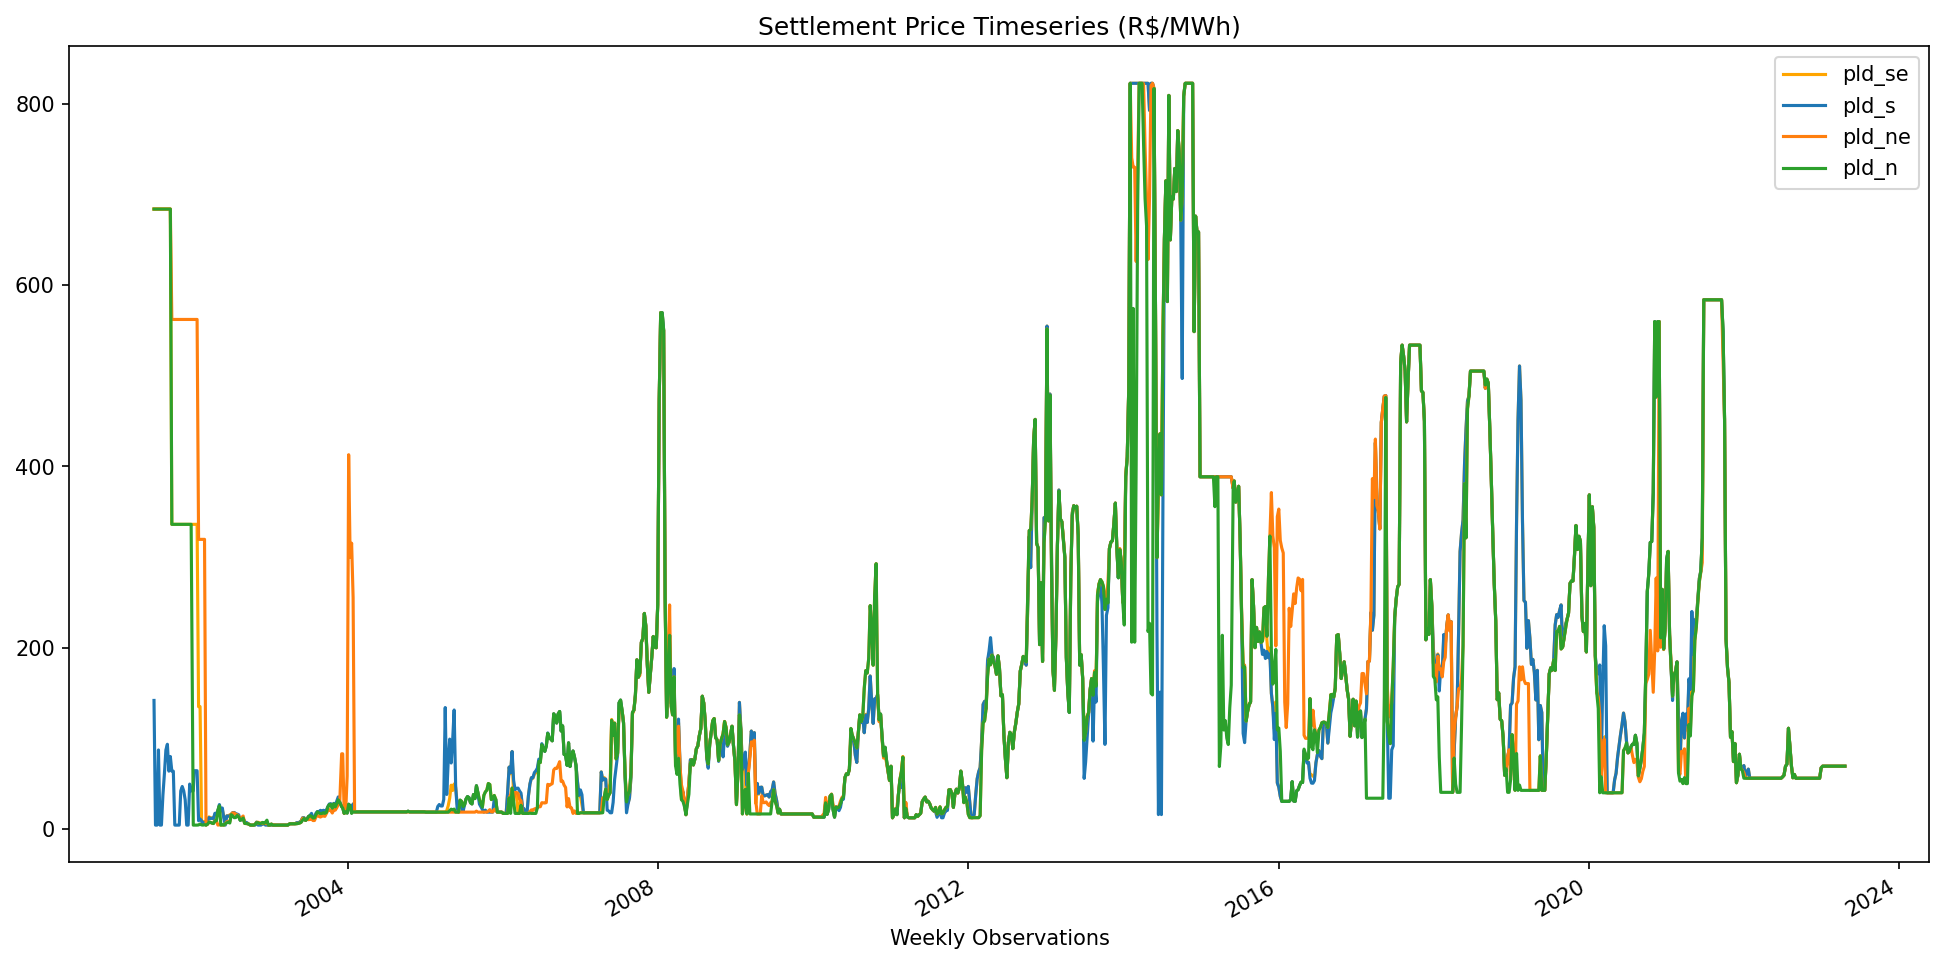

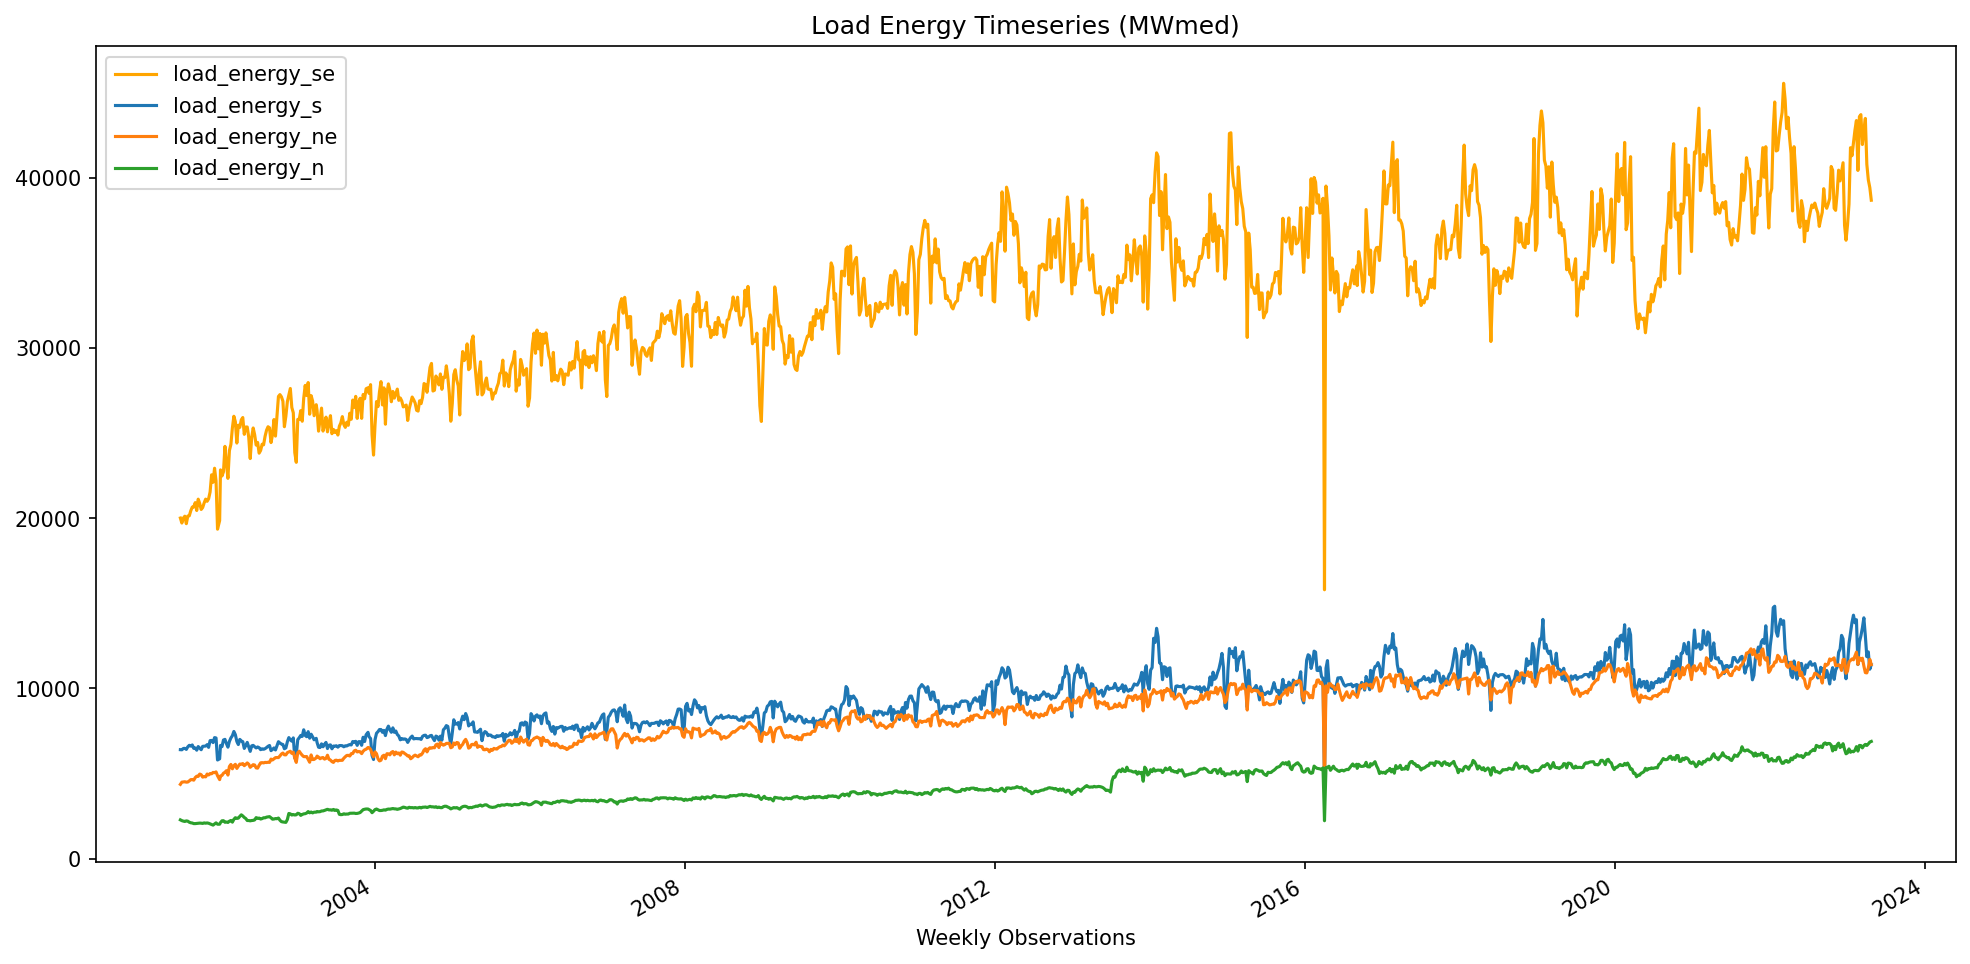

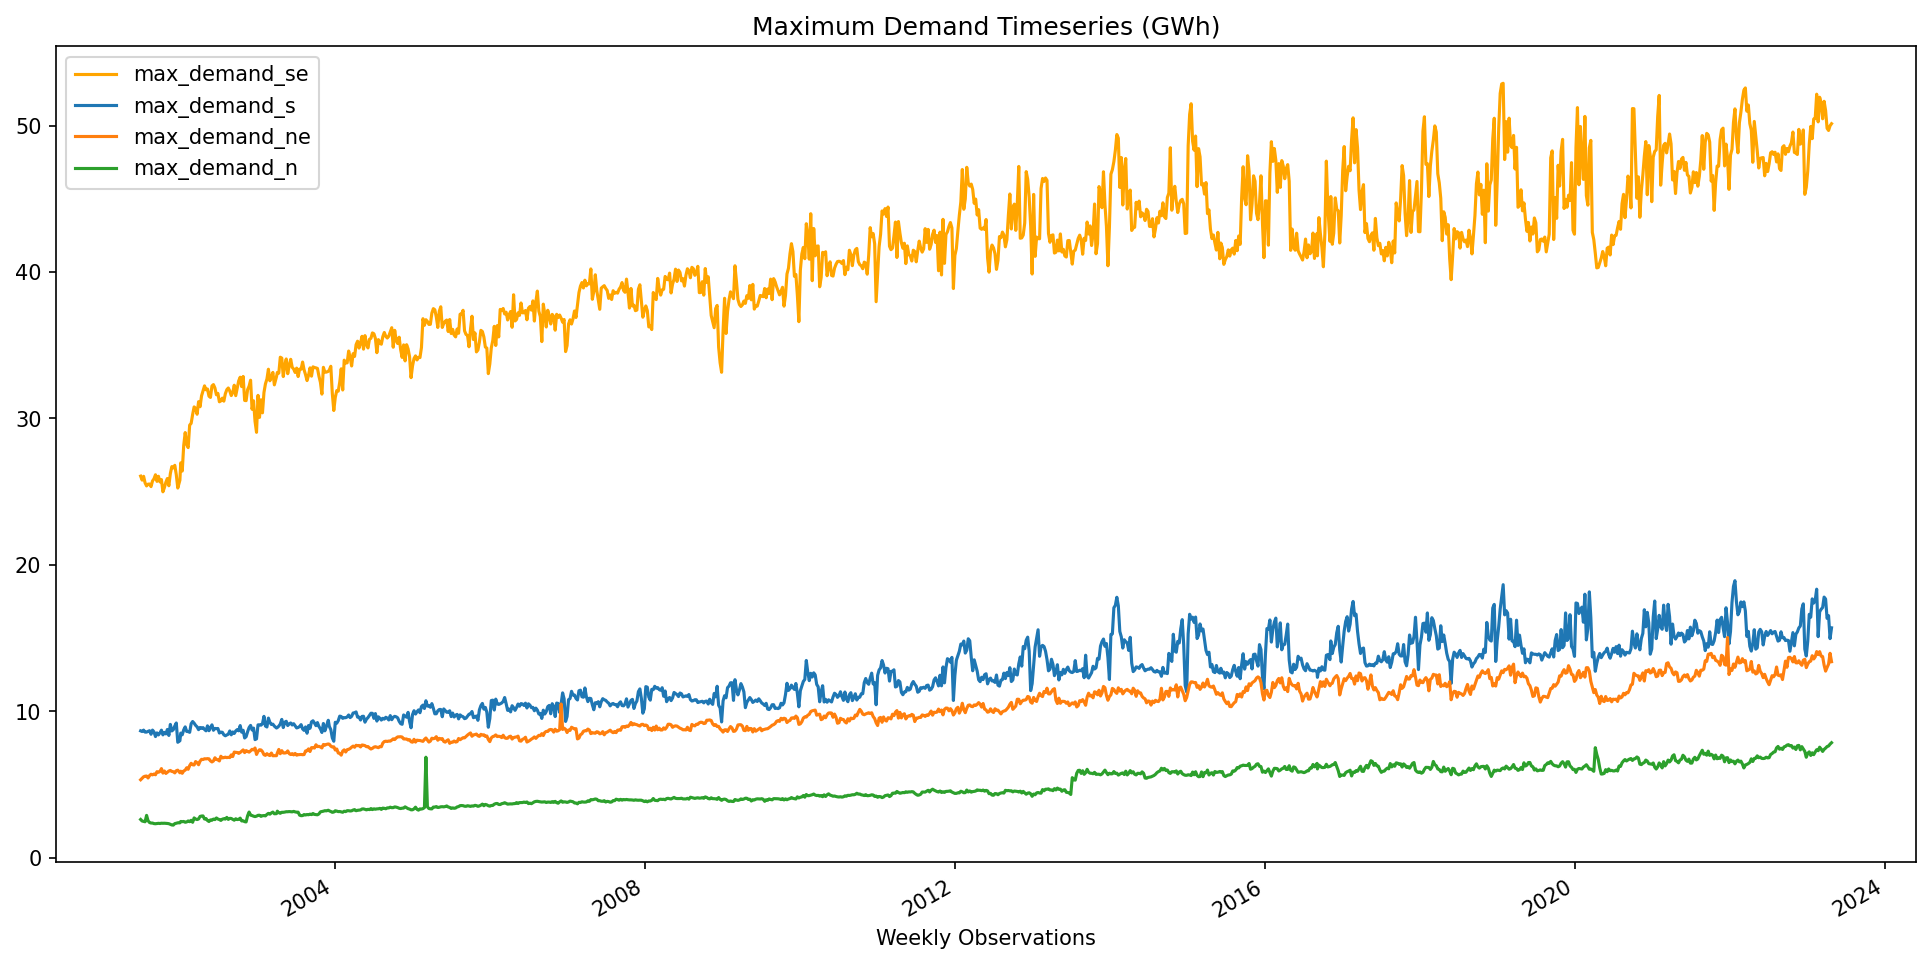

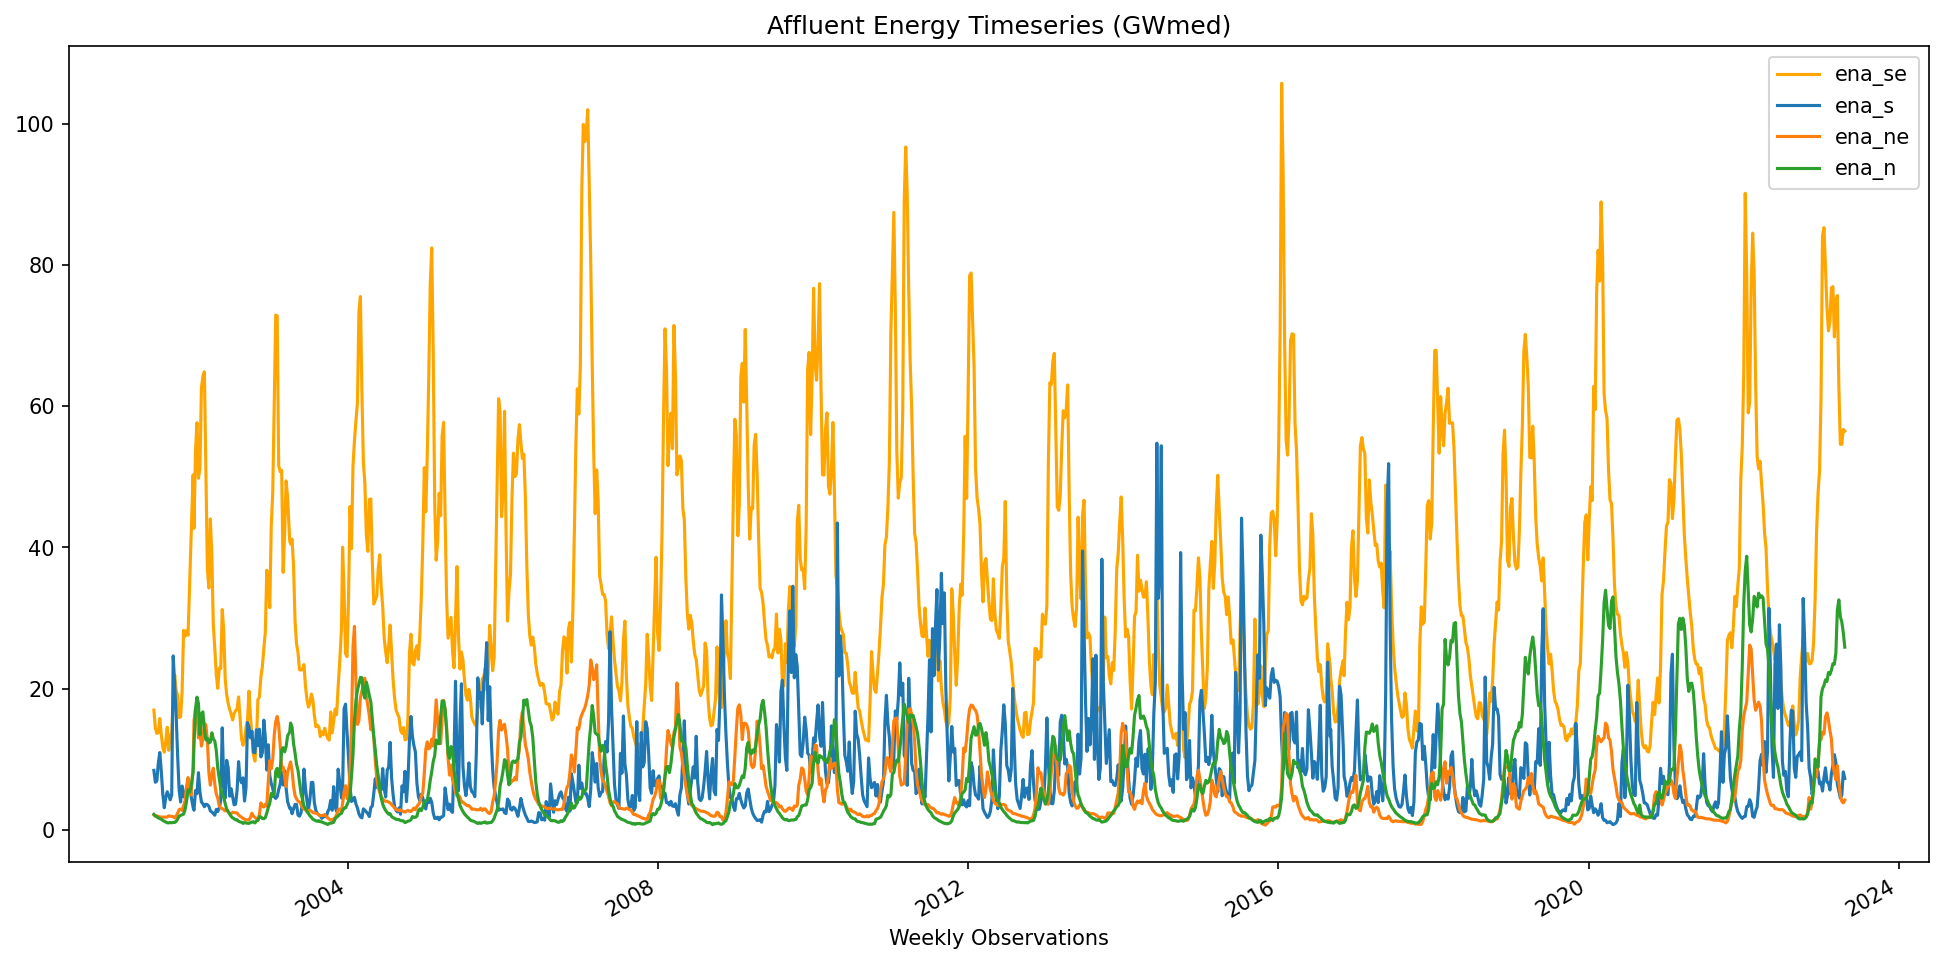

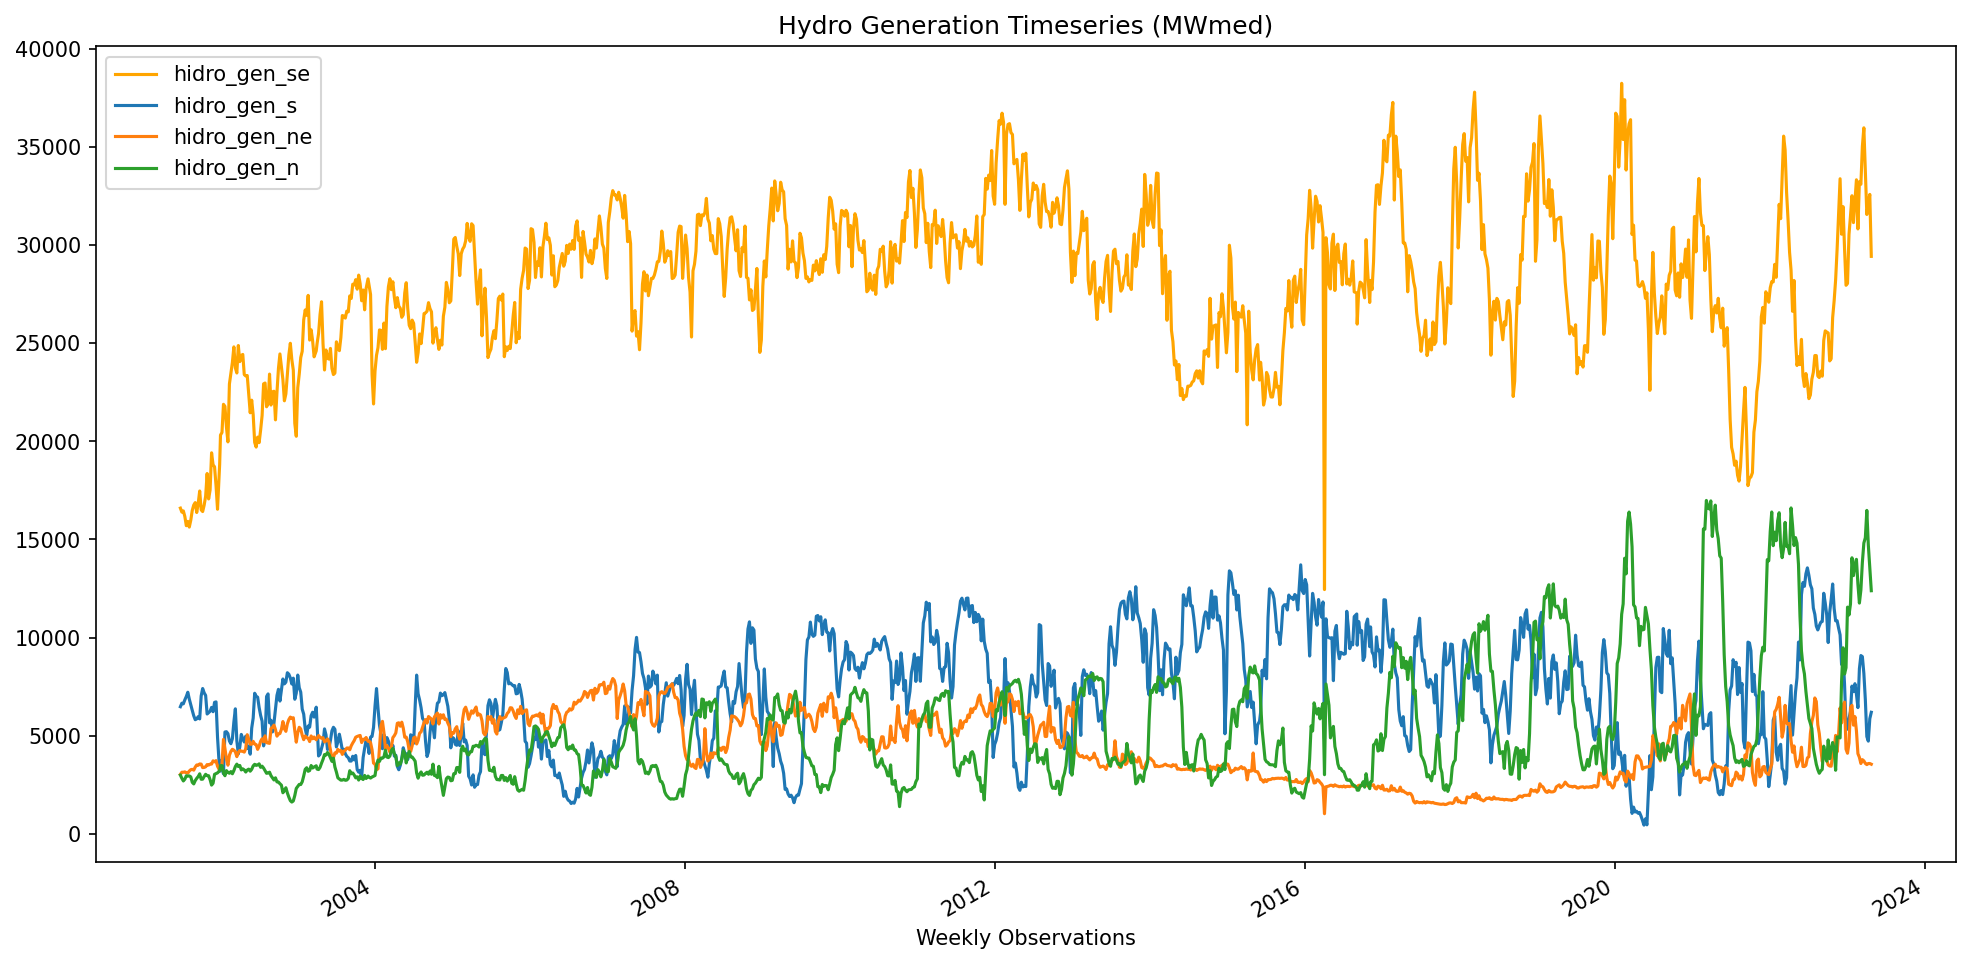

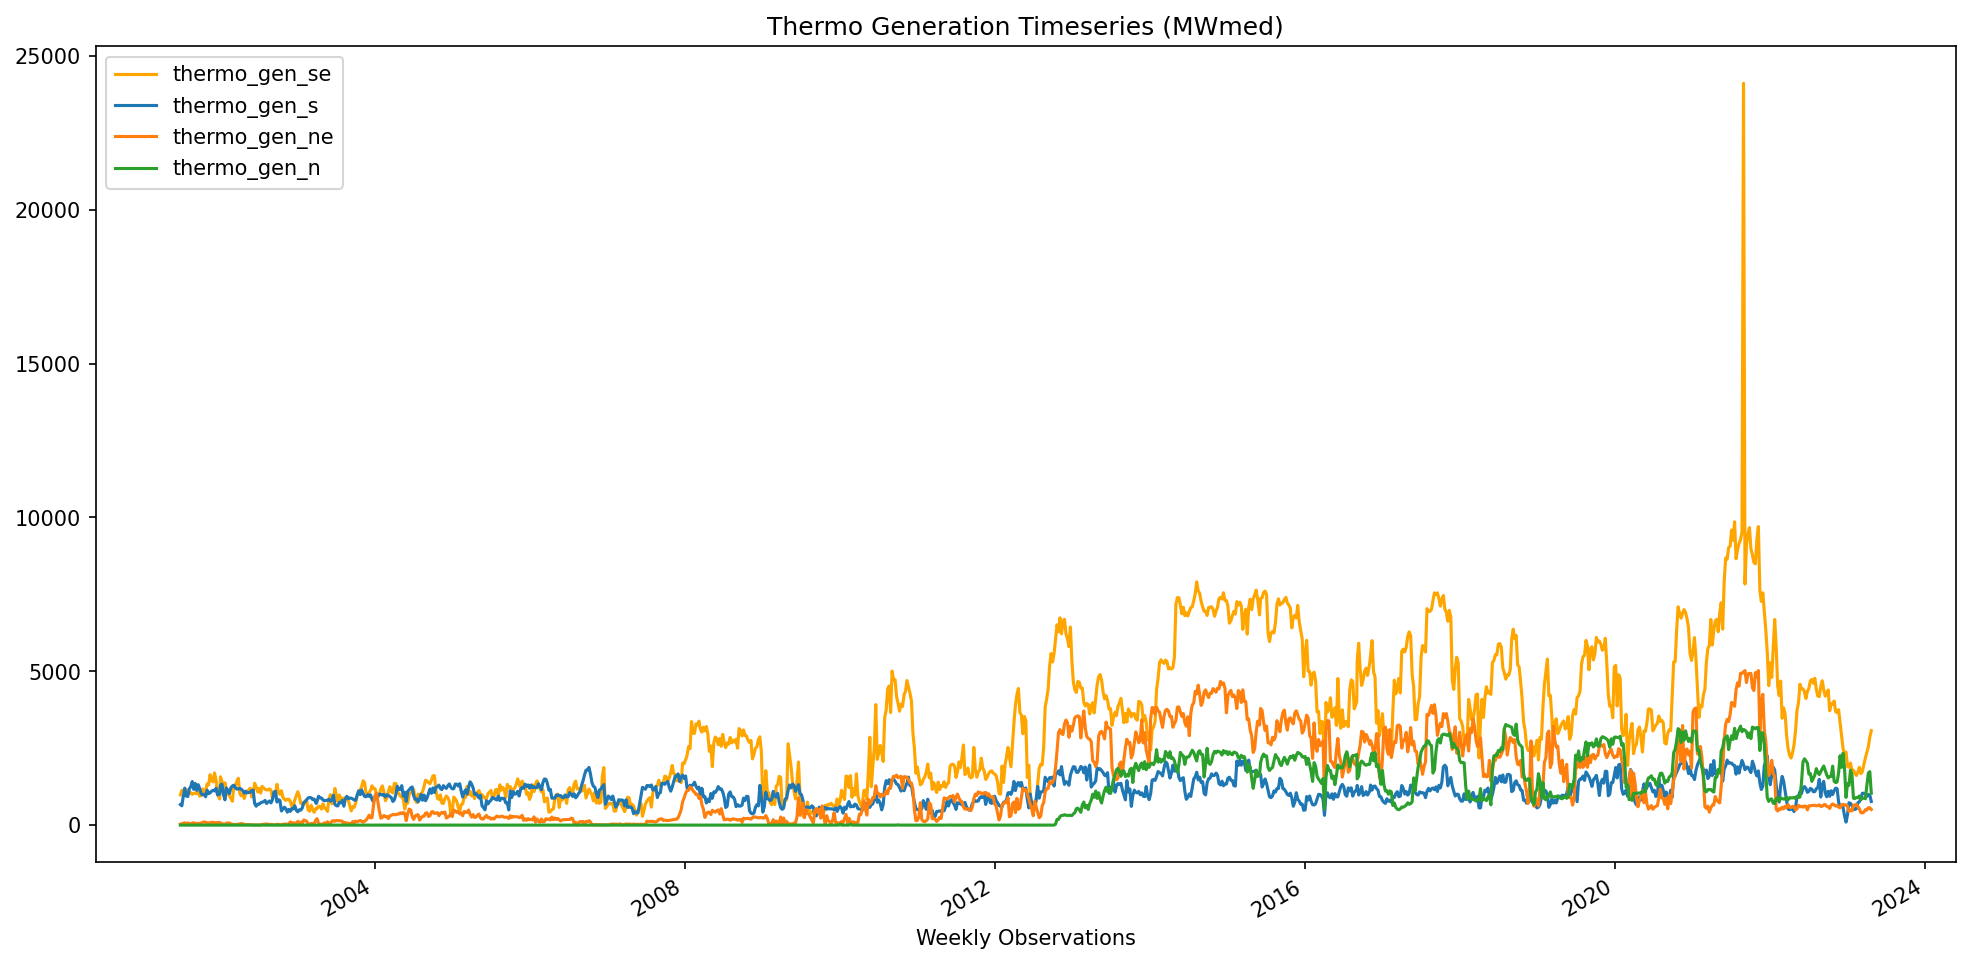

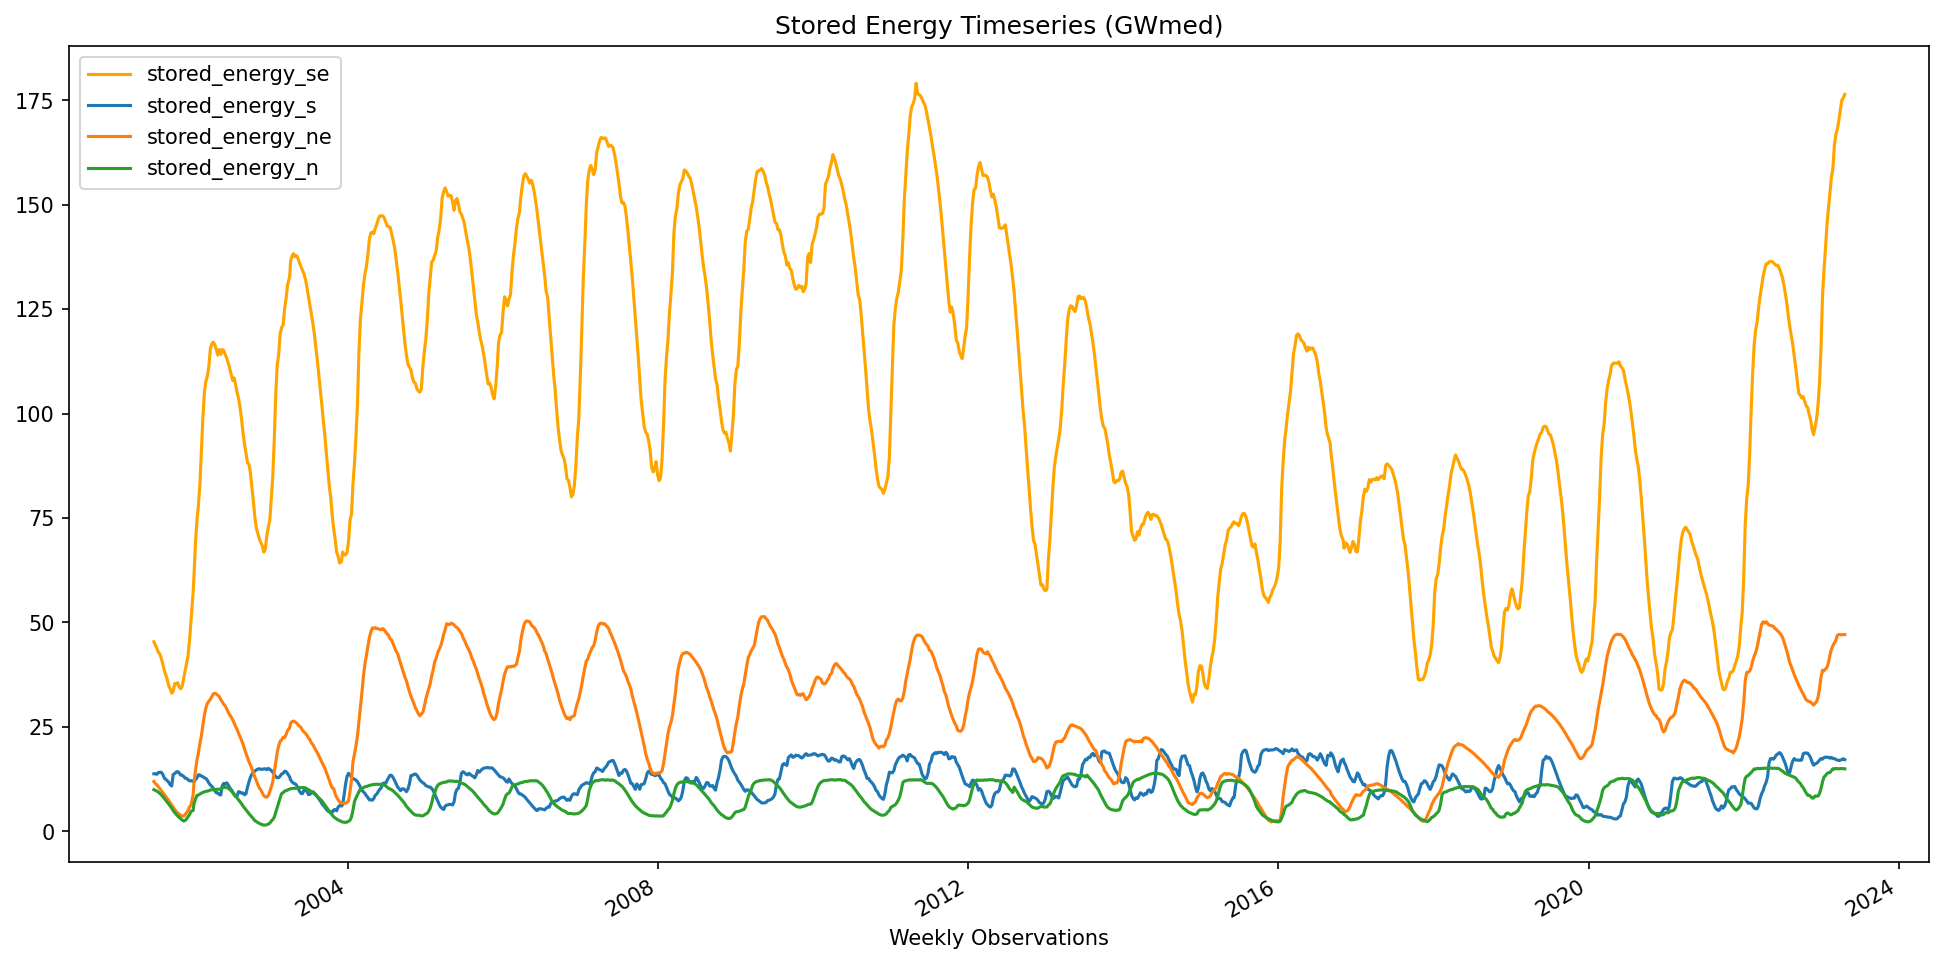

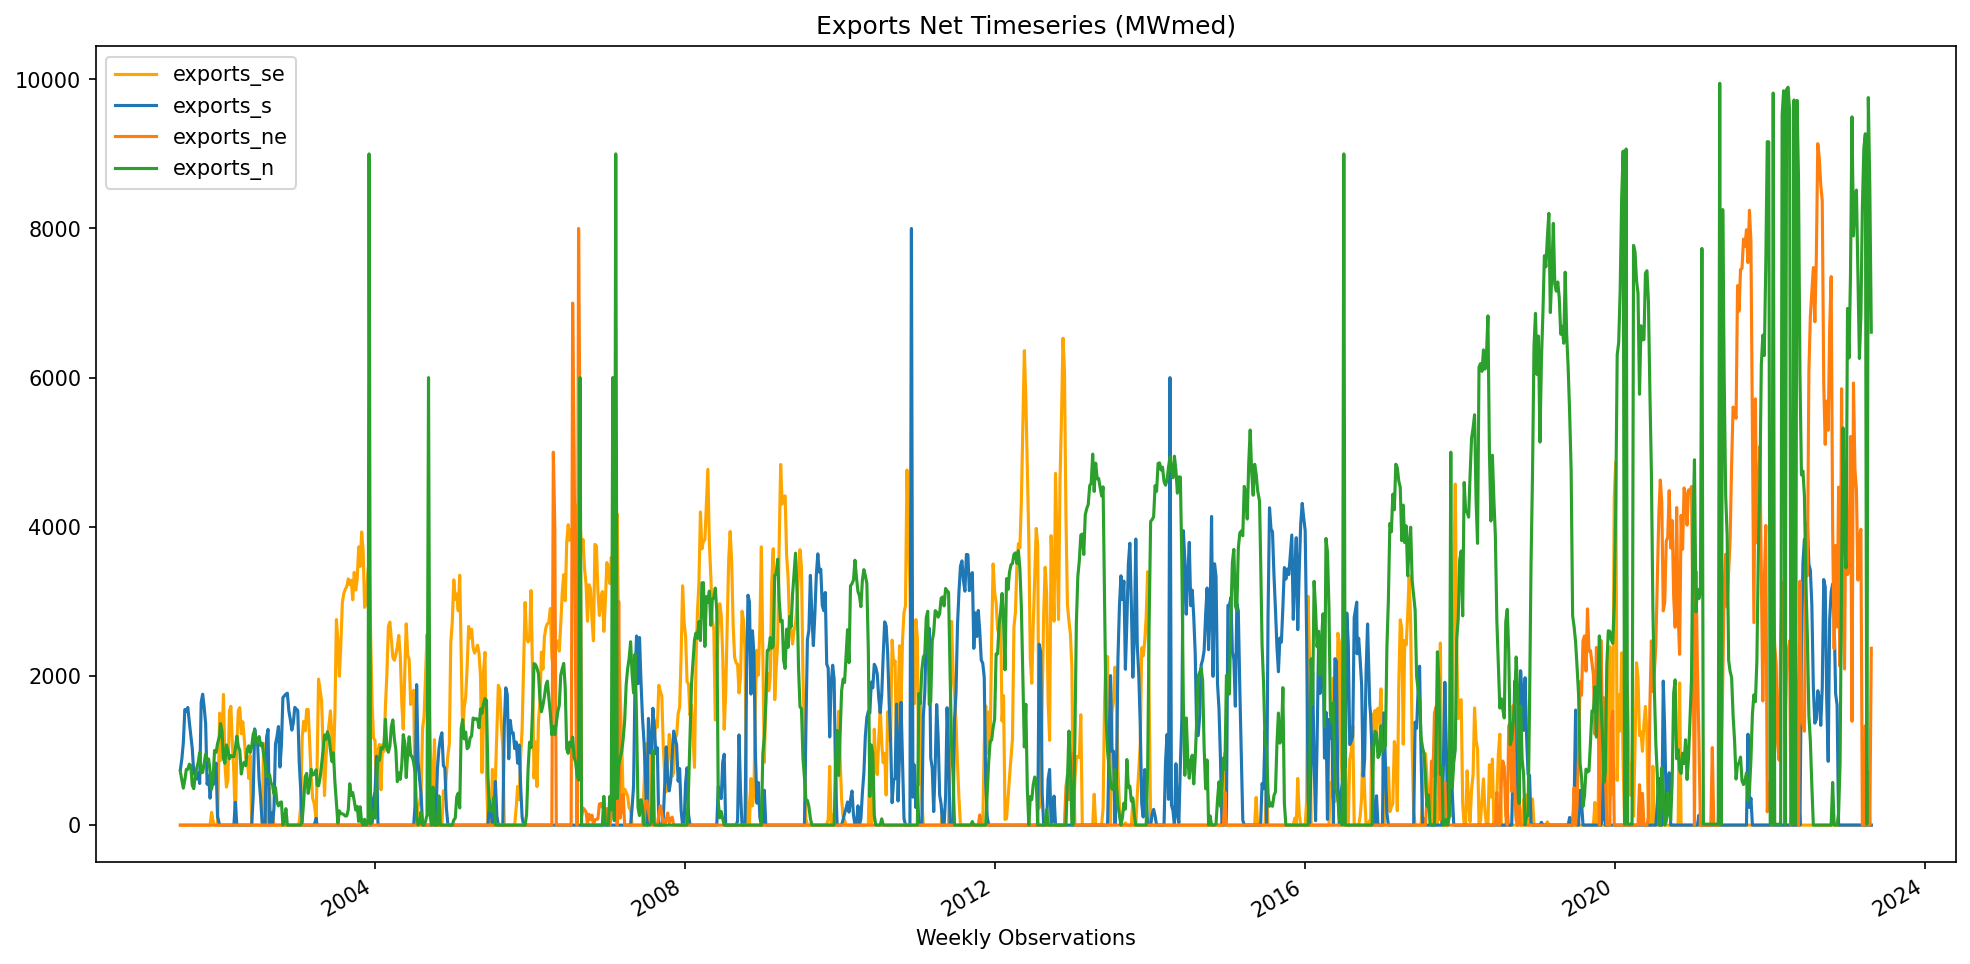

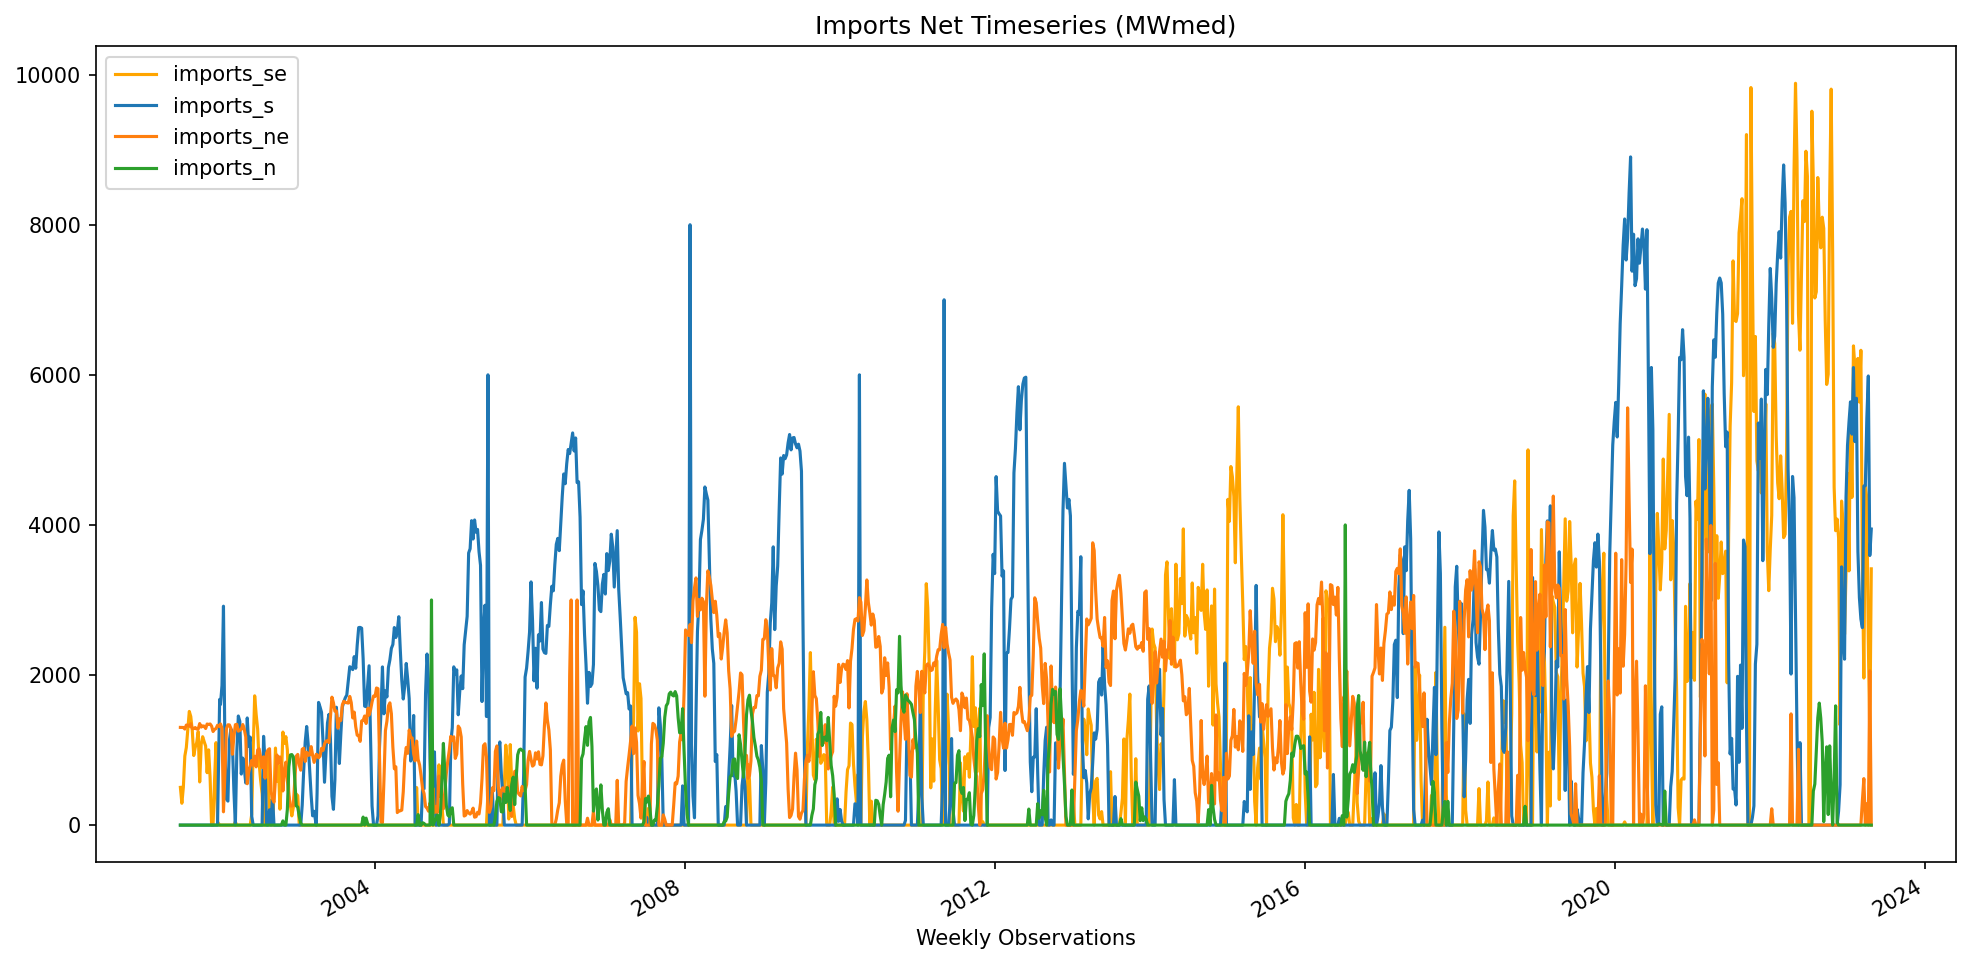

In [9]:
get_plot(df_pld,input_name='pld',title='Settlement Price Timeseries (R$/MWh)')
get_plot(df_load,input_name='load_energy',title='Load Energy Timeseries (MWmed)')
get_plot(df_demand,input_name='max_demand',title='Maximum Demand Timeseries (GWh)')
get_plot(df_ena,input_name='ena',title='Affluent Energy Timeseries (GWmed)')
get_plot(df_hidro,input_name='hidro_gen',title='Hydro Generation Timeseries (MWmed)')
get_plot(df_thermo,input_name='thermo_gen',title='Thermo Generation Timeseries (MWmed)')
get_plot(df_stored,input_name='stored_energy',title='Stored Energy Timeseries (GWmed)')
get_plot(df_exports,input_name='exports',title='Exports Net Timeseries (MWmed)')
get_plot(df_imports,input_name='imports',title='Imports Net Timeseries (MWmed)')

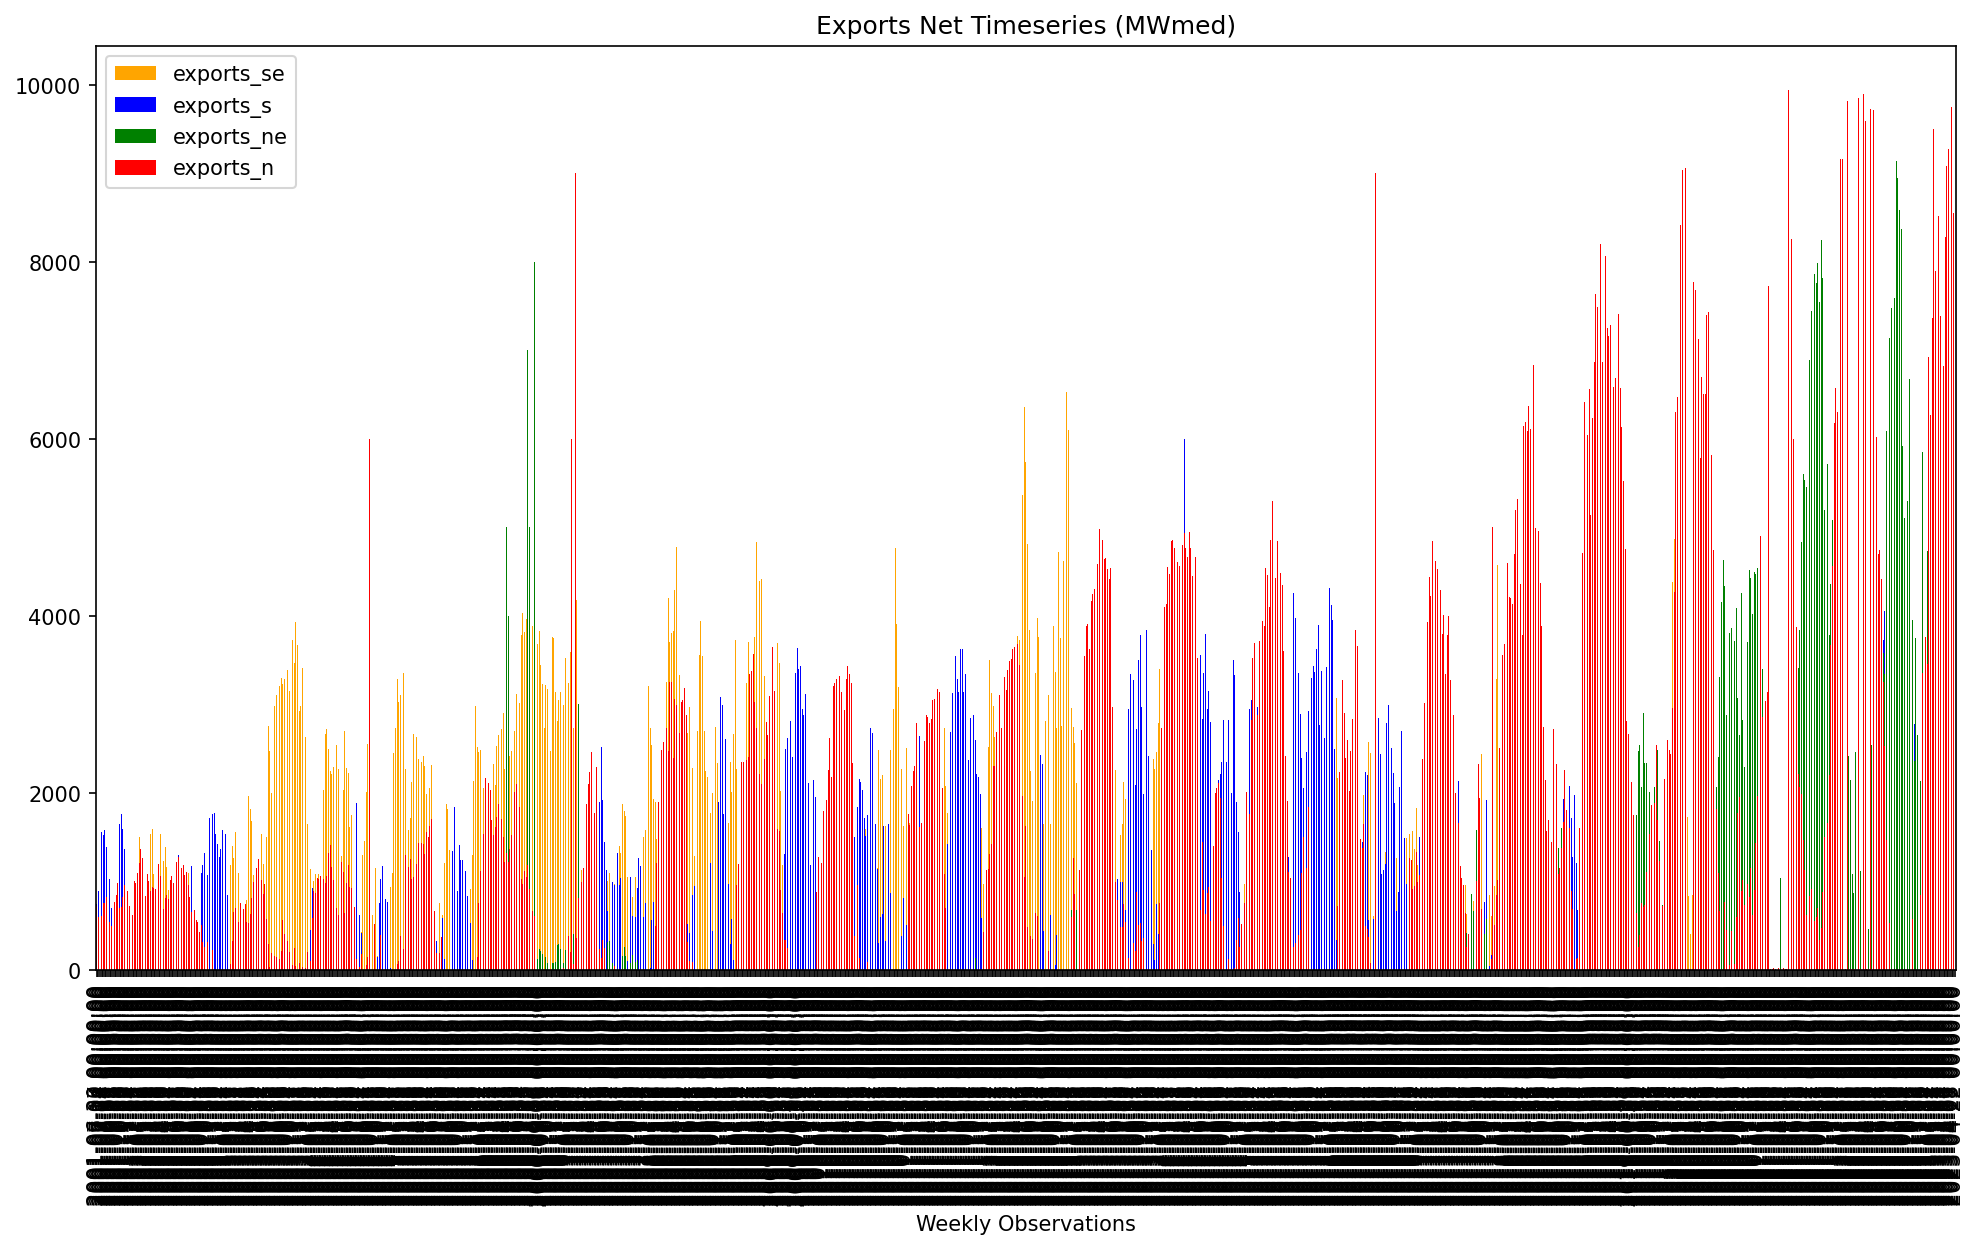

In [10]:
get_plot_bar(df_exports,input_name='exports',title='Exports Net Timeseries (MWmed)')